<style>
    .title_div {
    padding: 60px;
    text-align: center;
    background: #ffffff;
    }
    #title {
        color: #f2a900;
        font-size: 80px;
    }
    #subtitle {
        color: #4d4d4e;
        font-size: 20px;
    }
</style>

<div class="title_div">
  <h1 id="title">ECDSA</h1>
  <p id="subtitle">Elliptic Curve Digital Signature Algorithm</p>
</div>

<div style="color:red; text-align: center; padding: 60px">
⚠ The following examples are just to see how ECDSA work; no recommended to use this algorithms for real world signing applications. ⚠
</div>

## TOC:
* [Parameters](#parameters)
* [Elliptic Curve Mathematics](#ec-math)
    * [Modular Inverse](#modular-inverse)
    * [Double](#double)
    * [Add](#add)
    * [Multiply](#multiply)
        * [Double-and-add algorithm](#uber-multiply)
* [ECDSA](#ecdsa)
    * [Key Generation](#key-gen)
    * [Sign](#sign)
        * [Bad signing practice](#bad-sign)
    * [Verify](#verify)
* [Encoding](#encoding)
    * [DER encoding (sig)](#der-encoding)
    * [Uncompressed SEC (PK)](#uncompressed-sec)
    * [Compressed SEC (PK)](#compressed-sec)
* [Test](#test)

In [1]:
from IPython.display import clear_output
from time import sleep, time
from hashlib import sha256
from secrets import randbelow

# EC plot
import numpy as np
import matplotlib.pyplot as plt

# Also needed (Test)
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.exceptions import InvalidSignature

***
## Parameters<a class="anchor" id="parameters"></a>

The following variables are the ones used in secp256k1, the elliptic curve used in Bitcoin.<br></br>
Elliptic curve fuction:   $y^2 = x^3 + ax + b$

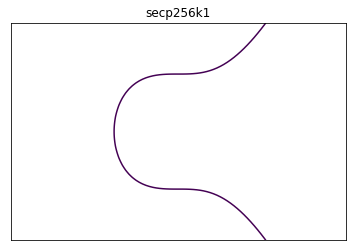

In [2]:
a = 0
b = 7

# prime field
p = 2**256 - 2**32 - 2**9 - 2**8 - 2**7 - 2**6 - 2**4 - 1

# order
n = 115792089237316195423570985008687907852837564279074904382605163141518161494337

G = [# genarator point
  55066263022277343669578718895168534326250603453777594175500187360389116729240,
  32670510020758816978083085130507043184471273380659243275938904335757337482424
]

# Ploting curve
y, x = np.ogrid[-5:5:100j, -5:5:100j]
plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - x * a - b, [0])
plt.title('secp256k1')
frame1 = plt.gca()
frame1.axes.xaxis.set_visible(False)
frame1.axes.yaxis.set_visible(False)
plt.show()

***
## Elliptic Curve Mathematics<a class="anchor" id="ec-math"></a>


### Modular Inverse<a class="anchor" id="modular-inverse"></a>

Extended Euclidean algorithm

In [3]:
def inverse(a, m = p):
    m_orig = m
    if a == 0:
        raise ZeroDivisionError(f"Variable a={a}; should be bigger than 0.")
    a = a % m
    prevy, y = 0, 1
    while a > 1:
        q = m // a
        y, prevy = prevy - q * y, y
        a, m = m % a, a
    return y % m_orig

print(inverse(13, 47))
print(pow(13, -1, 47)) # pyhton3.8+ and above 

29
29


In a finite field you can multiply by the inverse of a number to achieve the same result as division.

In [4]:
def animation(y, m, x = 8):

    for i in range(x, x*y+1):
        print("Finite Fields: Multiplication")
        pos = i % m

        print(" "+" "*pos+str(pos))
        print("0"+" "*pos+"\u21E9"+" "*(m-pos-1)+str(m))
        print("|"+"\u2022"*m+"|")
        print(" "+" "*x+"\u21EA")

        print("\n{} * {} = {}".format(x, y, pos))
    
        if i == x:
            sleep(1)
        else:
            sleep(.05)
        clear_output(wait=True)
    result = pos
    sleep(1.2)
    hit = []
    for i in range(result + 1, result * pow(y, -1, m) + 1):
        print("Finite Fields: Multiplication (Find Inverse)")
        pos = i % m
        if not i % result:
            hit.append(pos)

        print(" "+" "*pos+str(pos))
        print("0"+" "*pos+"\u21E9"+" "*(m-pos-1)+str(m))
        print("|"+"".join(['\u2022' if i not in hit else '\033[92m\u2022\033[0m' for i in range(m)])+"|")
        print(" "+" "*x+"\u21EA")

        print("\n{} * {} = {}".format(x, y, result))
        print("{} * {} = {}".format(result, i // result, pos))
    
        sleep(.02)
        clear_output(wait=True)

animation(13, 47)

Finite Fields: Multiplication (Find Inverse)
         8
0        ⇩                                      47
|•••••••••••••••••••••••••••••••••••••••••••••••|
         ⇪

8 * 13 = 10
10 * 29 = 8


### Double<a class="anchor" id="double"></a>

Used in case the two points are the same. We calculate the tangent to the point and find out where else does intersect the curve.

$slope = (3x₁² + a) / 2y₁$<br>
$x = slope² - 2x₁$<br>
$y = slope \times (x₁ - x) - y₁$

In [5]:
def double(point):
    slope = ((3 * point[0] ** 2 + a) * inverse((2 * point[1]), p)) % p
    x = (slope ** 2 - (2 * point[0])) % p
    y = (slope * (point[0] - x) - point[1]) % p
    return (x, y)

result = double(G)
print(f"double(G): {{\n\tx: {result[0]},\n\ty: {result[1]}\n}}")

double(G): {
	x: 89565891926547004231252920425935692360644145829622209833684329913297188986597,
	y: 12158399299693830322967808612713398636155367887041628176798871954788371653930
}


### Add<a class="anchor" id="add"></a>

Used when the points are different.

$slope = (y₁ - y₂) / (x₁ - x₂)$<br>
$x = slope² - x₁ - x₂$<br>
$y = slope \times (x₁ - x) - y₁$

In [6]:
def add(point1, point2):
  if point1 == point2:
    return double(point1)
  slope = ((point1[1] - point2[1]) * inverse(point1[0] - point2[0], p)) % p
  x = (slope ** 2 - point1[0] - point2[0]) % p
  y = ((slope * (point1[0] - x)) - point1[1]) % p
  return (x, y)

T = add(G, G)
print(f"T: {{\n\tx: {T[0]},\n\ty: {T[1]}\n}}")
T2 = add(T, G)
print(f"T2: {{\n\tx: {T2[0]},\n\ty: {T2[1]}\n}}")

del T, T2

T: {
	x: 89565891926547004231252920425935692360644145829622209833684329913297188986597,
	y: 12158399299693830322967808612713398636155367887041628176798871954788371653930
}
T2: {
	x: 112711660439710606056748659173929673102114977341539408544630613555209775888121,
	y: 25583027980570883691656905877401976406448868254816295069919888960541586679410
}


### Multiply<a class="anchor" id="multiply"></a>
Used for sucesive additions.

In [7]:
def multiply(constant, point = G):
    acu = add(point, point)
    for _ in range(constant-2):
        acu = add(acu, point)
    return acu

start = time()
result = multiply(40000)
print(f"Execution time: {(time() - start)*1000} ms")
print(f"Result: {{\n\tx: {result[0]},\n\ty: {result[1]}\n}}")

del start, result

Execution time: 2028.754711151123 ms
Result: {
	x: 45144681238022915379838256640648974390095578890737782493692183842300544374804,
	y: 15493911184894630123643928078266102650003862558761004463646228136434723692345
}


#### Double-and-add algorithm<a class="anchor" id="uber-multiply"></a>

Amazingly, if you convert any integer in to its binary representation, the 1s and 0s will provide a map for the sequence of double() and add() operations you need to perform to reach that multiple.

Working from left to right and ignoring the first number:

* 0 = double
* 1 = double and add

<pre>
e.g. 1 * 21

21 = 10101 (binary)
      │││└ double and add = 21
      ││└─ double         = 10
      │└── double and add = 5
      └─── double         = 2
                            1  <- start here
</pre>

In [8]:
def uber_multiply(constant, point = G):
    current = point
    binary = bin(constant)[3:]
    for i in binary:
        current = double(current)
        if i == '1':
            current = add(current, point)
    return current

start = time()
result = uber_multiply(40000)
print(f"Execution time: {(time() - start)*1000} ms")
print(f"Result: {{\n\tx: {result[0]},\n\ty: {result[1]}\n}}")

del start, result

Execution time: 0.9989738464355469 ms
Result: {
	x: 45144681238022915379838256640648974390095578890737782493692183842300544374804,
	y: 15493911184894630123643928078266102650003862558761004463646228136434723692345
}


***
## ECDSA <a class="anchor" id="ecdsa"></a>

### Key Generation <a class="anchor" id="key-gen"></a>

The private key should be a random number less than orden 'n'.

In [9]:
d = 112757557418114203588093402336452206775565751179231977388358956335153294300646 # Pvivate key
Q = uber_multiply(d)

print("Public {}: {{\n\tx: {},\n\ty: {}\n}}".format("\U0001F511",Q[0], Q[1]))

Public 🔑: {
	x: 33886286099813419182054595252042348742146950914608322024530631065951421850289,
	y: 9529752953487881233694078263953407116222499632359298014255097182349749987176
}


### Sign<a class="anchor" id="sign"></a>

What we need:
1. Salt: $k$
2. Message Hash: $z$
3. Private Key: $d$

In [10]:
k = 18181818181818181818181
print(f"Salt: {k}")

message = "ECDSA (Elliptic Curve Digital Signature Algorithm)"
print(f"Message: {message}")

z = sha256(message.encode('ascii')).digest()
z = int.from_bytes(z, 'big')
print(f"Hash digest in decimal: {z}")

print(f"Private key: {d}")

Salt: 18181818181818181818181
Message: ECDSA (Elliptic Curve Digital Signature Algorithm)
Hash digest in decimal: 49410833204725140173526597860441273720434304053996485655430536493502439593083
Private key: 112757557418114203588093402336452206775565751179231977388358956335153294300646


A signature is compose by the conbination of $r$ and $s$:

$r = (G \times k)mod(n)$<br>
We take the random number $k$ and multiply it by the generator point to get a random point $R$. We only actually use the x-coordinate of this point, and we call this lowercase $r$.

$s = k⁻¹ \times (z + d \times r)) mod(n)$<br>
This is a unique number created from a combination of $z$ and $d$, which is also bound to the random point using $r$.

In [11]:
def sign(private_k, m_hash, salt = None):

    if salt == None:
        salt = randbelow(n) # Random number within finite field order.

    r = uber_multiply(salt)[0] % n
   
    s = (inverse(salt, n) * (m_hash + private_k * r)) % n

    return (r, s)


signature = sign(d, z, k)

print(f"Signature: {{\n\tx: {signature[0]},\n\ty: {signature[1]}\n}}")

Signature: {
	x: 54767518919804132415261250426954620798001685863099591615502827291246864032477,
	y: 98602259575904705330380232146105755454407891657434652824036155561569926413905
}


#### Bad signing practice<a class="anchor" id="bad-sign"></a>

Is streamly important to have a good random source for $k$; because if someone realize we are using the same $r$ value in different signs they can trace back our private key.

In [12]:
prv_k = 1111222233334444555566667777888899990000
pub_k = uber_multiply(prv_k)

k = 12345 # No random on pourpose.

digest1 = int.from_bytes(sha256(b'Just a simple message.').digest(), 'big')
bad_sig1 = sign(prv_k, digest1, k)

digest2 = int.from_bytes(sha256(b'I have used the same k value.').digest(), 'big')
bad_sig2 = sign(prv_k, digest2, k)

k_recovery = ((digest1 - digest2) * inverse(bad_sig1[1] - bad_sig2[1], n)) % n

d_recovery = ((k_recovery * bad_sig1[1] - digest1) * inverse(bad_sig1[0], n)) % n

print("Private key ({}) reversed: {}".format(prv_k, d_recovery == prv_k))

del k_recovery, d_recovery, digest1, digest2, bad_sig1, bad_sig2, prv_k, pub_k, k

Private key (1111222233334444555566667777888899990000) reversed: True


### Verify<a class="anchor" id="verify"></a>

We calculate point one and point two; trace a line thought those and in the third intersection calculate the reflection. If this new $R$ value first term matches with signature $r$, the sign is correct.

$R = (s⁻¹ \times z)G + (s⁻¹ \times r)Q$

What we need:
1. Public key: $Q$
2. Message: So we can create $z$.
3. Signature: $[r, s]$



In [13]:
def verify(public_k, signature, hash):

    point1 = uber_multiply(inverse(signature[1], n) * hash)
    point2 = uber_multiply((inverse(signature[1], n )* signature[0]), public_k)
    
    point3 = add(point1, point2)
    return point3[0] == signature[0]

def pretty_verify(*args):
    message_digest = sha256(args[2].encode('ascii')).digest()
    message_digest = int.from_bytes(message_digest, 'big')
    print("{} ".format("\u2705" if verify(*args[:2], message_digest) else "\u274C"), end="")
    print(args[2])

print(f"SHA-256 digest: {z}")
print(f"Signature [r, s]: {{\n\tx: {signature[0]},\n\ty: {signature[1]}\n}}")
print(f"Public key Q: {{\n\tx: {Q[0]},\n\ty: {Q[1]}\n}}")

pretty_verify(Q, signature, message)


SHA-256 digest: 49410833204725140173526597860441273720434304053996485655430536493502439593083
Signature [r, s]: {
	x: 54767518919804132415261250426954620798001685863099591615502827291246864032477,
	y: 98602259575904705330380232146105755454407891657434652824036155561569926413905
}
Public key Q: {
	x: 33886286099813419182054595252042348742146950914608322024530631065951421850289,
	y: 9529752953487881233694078263953407116222499632359298014255097182349749987176
}
✅ ECDSA (Elliptic Curve Digital Signature Algorithm)


***
## Encoding <a class="anchor" id="encoding"></a>

### DER encoding <a class="anchor" id="der-encoding"></a>

Encoding the signature:

1. Start with the 0x30 byte.
2. Encode the length of the rest of the signature (usually 0x44 or 0x45) and append.
3. Append the marker byte, 0x02.
4. Encode $r$ as a big-endian integer, but prepend it with the 0x00 byte if $r’s$ first byte ≥ 0x80. Prepend the resulting length to $r$. Add this to the result.
5. Append the marker byte, 0x02.
6. Encode $s$ as a big-endian integer, but prepend with the 0x00 byte if $s’s$ first byte ≥ 0x80. Prepend the resulting length to $s$. Add this to the result.

In [14]:
colors = {'purple':'\033[95m', 'red':'\033[91m', 'yellow':'\033[93m', 'green':'\033[92m', 'blue':'\033[94m'}

def der_encoding(signature):

    rbin = signature[0].to_bytes(32, byteorder='big')
    rbin = rbin.lstrip(b'\x00')
    
    if rbin[0] & 0x80:
        rbin = b'\x00' + rbin
    result = bytes([2, len(rbin)]) + rbin

    sbin = signature[1].to_bytes(32, byteorder='big')
    sbin = sbin.lstrip(b'\x00')
    
    if sbin[0] & 0x80:
        sbin = b'\x00' + sbin
    result += bytes([2, len(sbin)]) + sbin
    return bytes([0x30, len(result)]) + result

encoded_sig = der_encoding(signature)

hex_sig = encoded_sig.hex()

r_len = int(hex_sig[6:8], 16) * 2 + 8

print(colors['red']+hex_sig[0:2], end="")
print(colors['blue']+hex_sig[2:4], end="")
print(colors['purple']+hex_sig[4:6], end="")
print(colors['green']+hex_sig[6:8], end="")
print(colors['yellow']+hex_sig[8:r_len], end="")
print(colors['purple']+hex_sig[r_len:r_len+2], end="")
print(colors['green']+hex_sig[r_len+2:r_len+4], end="")
print(colors['yellow']+hex_sig[r_len+4:], end="\n")

print(f"{colors['red']}\u2589 {'Marker'}")
print(f"{colors['blue']}\u2589 {'Length of sig'}")
print(f"{colors['purple']}\u2589 {'[r, s] markers'}")
print(f"{colors['green']}\u2589 {'[r, s] lenghts'}")
print(f"{colors['yellow']}\u2589 {'[r, s]'}")

del r_len, hex_sig



30450220791551345a2e80dc53dd2d607429c98be30c5bfa38258dfeb722e049b696e2dd022100d9fee6b4e7fef80cf80770eb04f01db3be7fe024cc53f4b73435cc782d3a7e51
▉ Marker
▉ Length of sig
▉ [r, s] markers
▉ [r, s] lenghts
▉ [r, s]


### Uncompressed SEC <a class="anchor" id="uncompressed-sec"></a>

Prefix '04' follow by the X and Y cordinates.

In [15]:
def uncompress_sec(public_key):
    return b'\x04' + public_key[0].to_bytes(32, 'big') + public_key[1].to_bytes(32, 'big')


uncompressed_pk = uncompress_sec(Q)
uncompressed_pk_hex = uncompressed_pk.hex()

print(colors['purple']+uncompressed_pk_hex[0:2], end="")
print(colors['yellow']+uncompressed_pk_hex[2:66], end="")
print(colors['red']+uncompressed_pk_hex[66:], end="\n")
print(f"{colors['purple']}\u2589 {'Marker'}")
print(f"{colors['yellow']}\u2589 {'X coordinate'}")
print(f"{colors['red']}\u2589 {'Y coordinate'}")

del uncompressed_pk, uncompressed_pk_hex

044aeaf55040fa16de37303d13ca1dde85f4ca9baa36e2963a27a1c0c1165fe2b11511a626b232de4ed05b204bd9eccaf1b79f5752e14dd1e847aa2f4db6a52768
▉ Marker
▉ X coordinate
▉ Y coordinate


### Compressed SEC <a class="anchor" id="compressed-sec"></a>
We use the X cordinate with a prefix marker denotating if the Y cordinate is or or even.

In [16]:
def sec_pk(public_key, compressed=True):
        # return byte version of the PK
        if compressed:
            if public_key[1] % 2 == 0:
                return b'\x02' + public_key[0].to_bytes(32, 'big')
            else:
                return b'\x03' + public_key[0].to_bytes(32, 'big')
        else:
            return b'\x04' + public_key[0].to_bytes(32, 'big') + public_key[1].to_bytes(32, 'big')

compressed_pk = sec_pk(Q)
compressed_pk_hex = compressed_pk.hex()

print(colors['purple']+compressed_pk_hex[0:2], end="")
print(colors['yellow']+compressed_pk_hex[2:], end="\n")
print(f"{colors['purple']}\u2589 {'Marker'}")
print(f"{colors['yellow']}\u2589 {'X coordinate'}")

del compressed_pk_hex

024aeaf55040fa16de37303d13ca1dde85f4ca9baa36e2963a27a1c0c1165fe2b1
▉ Marker
▉ X coordinate


***
## Test <a class="anchor" id="test"></a>

Checking sign against a crypto secure library.

In [17]:
data = message.encode('ascii')

public_key = ec.EllipticCurvePublicKey.from_encoded_point( ec.SECP256K1(), compressed_pk)

try:
    public_key.verify(encoded_sig, data, ec.ECDSA(hashes.SHA256()))
    print("Everything correct.")
except InvalidSignature:
    print("Broken sign.")

del data, public_key

Everything correct.
